In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
     |████████████████████████████████| 315 kB 7.3 MB/s 
     |████████████████████████████████| 650 kB 29.7 MB/s 
     |████████████████████████████████| 324 kB 28.5 MB/s 
     |████████████████████████████████| 128 kB 49.0 MB/s 
     |████████████████████████████████| 467 kB 7.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=5ac1469f68b99d392d3f9784c188658547e6e52fdaf5aa674513f3e3a6f1ac40
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [2]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.8 MB/s 
     |████████████████████████████████| 1.3 MB 55.1 MB/s 
     |████████████████████████████████| 182 kB 67.0 MB/s 
     |████████████████████████████████| 7.6 MB 37.3 MB/s 


In [3]:
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [4]:
!cp ./drive/MyDrive/FDB.zip  ./ 

In [5]:
!unzip  FDB.zip

Archive:  FDB.zip
  inflating: FDB.db                  
  inflating: FDB.sqbpro              


In [6]:
import sqlite3
con = sqlite3.connect("FDB.db")

In [7]:
#Data
from google.colab import drive
import sqlite3
import json
#NEE

import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
import re
from spacy import displacy
from collections import Counter
from typing import List
import en_core_web_sm
import matplotlib.pyplot as plt
#Models
from datetime import timedelta
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
import numpy as np 

In [8]:
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
cursor =  con.cursor()

cursor.execute(sql_query)
tables = [ x[0]  for x in cursor.fetchall()]

In [9]:
tables

['us_equities_news_dataset', 'nasdaq_screener', 'stockHistory']

In [10]:
import gdown
trained_ner_url = "https://drive.google.com/drive/folders/1oIsO99-13fbDdYPXtxQwFYvQDy7WsIxx?usp=sharing"
gdown.download_folder(trained_ner_url, quiet=True)
nlp =spacy.load("/content/stocks_trained_ner")

def get_companies(article:str)-> List[str]:
  doc = nlp(article)
  results = []
  for ent in doc.ents:
      results.append(ent.label_)
  return list((set(results)))

In [11]:
sql_query = """SELECT * FROM 'us_equities_news_dataset'  """
cursor.execute(sql_query)
news = cursor.fetchall()

import pandas as pd
# Create your connection.
dfs = {}
for t in tables:
  dfs[t] = pd.read_sql_query(f"SELECT * FROM {t}", con)
dfs["us_equities_news_dataset"]["release_date"] = pd.to_datetime(dfs["us_equities_news_dataset"]["release_date"])
dfs["stockHistory"]["dateOfPrice"] = pd.to_datetime(dfs["stockHistory"]["dateOfPrice"])
dfs["stockHistory"] = dfs["stockHistory"].sort_values(["dateOfPrice"])

In [ ]:
tables

['us_equities_news_dataset', 'nasdaq_screener', 'stockHistory']

In [12]:
dfs["us_equities_news_dataset"]["release_date"].value_counts()

2020-01-30    486
2020-01-28    427
2020-01-29    405
2019-05-01    405
2020-01-22    399
             ... 
2010-06-16      1
2010-06-30      1
2008-11-16      1
2010-07-26      1
2010-03-22      1
Name: release_date, Length: 3635, dtype: int64

In [13]:
dfs["us_equities_news_dataset"]["release_date"].max() 

Timestamp('2020-02-13 00:00:00')

In [14]:
dfs["stockHistory"]["dateOfPrice"].min()

Timestamp('2018-01-11 00:00:00')

In [15]:
dfs["stockHistory"]

,symbol,dateOfPrice,open,high,low,close,volume
488761,MSI,2018-01-11,92.33,93.63,92.14,93.55,811903.0
126062,APA,2018-01-11,44.37,46.97,44.20,46.00,6712261.0
13538,KLAC,2018-01-11,106.64,106.75,104.96,106.24,968095.0
155312,CWST,2018-01-11,23.16,23.60,23.06,23.50,93589.0
192057,BBSI,2018-01-11,62.85,65.17,56.10,64.57,36945.0
...,...,...,...,...,...,...,...
486420,BKNG,2022-09-06,1837.91,1848.56,1780.09,1814.85,338295.0
439582,BA,2022-09-06,152.39,154.48,150.46,152.39,5205496.0
390401,ITRI,2022-09-06,48.12,48.12,46.22,46.65,377517.0
410307,EQIX,2022-09-06,628.00,636.37,625.70,631.84,285296.0


In [16]:
# we only have historical data from 2018 and later
# we also have news till 2020 
news_df = dfs["us_equities_news_dataset"][dfs["us_equities_news_dataset"]["release_date"] >= dfs["stockHistory"]["dateOfPrice"].min() - timedelta(7)]
stock_df = dfs["stockHistory"][dfs["stockHistory"]["dateOfPrice"] <= dfs["us_equities_news_dataset"]["release_date"].max()  + timedelta(7)]
news_df.drop(["provider"], axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


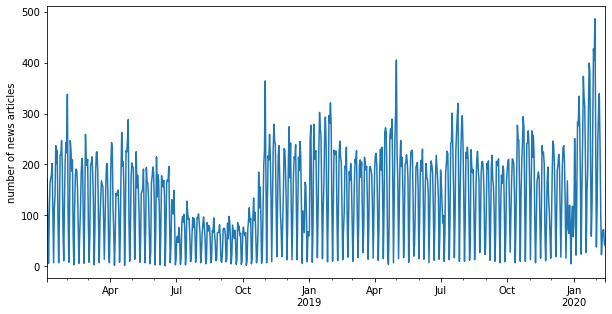

In [17]:
plt.figure(figsize=(10,5))
news_df["release_date"].value_counts().sort_index().plot()
plt.ylabel("number of news articles")
plt.show()

In [19]:
news_df["ticker"].value_counts() #

AAPL    9729
MSFT    4992
AMZN    3828
BA      3300
BAC     2598
        ... 
CIZN       1
SRL        1
CPHC       1
CVBF       1
CVLY       1
Name: ticker, Length: 674, dtype: int64

In [20]:
stock_history_symbols = stock_df.symbol.unique()
news_symbols = news_df.ticker.unique()
target_symbols = [ k for k in news_symbols if k in stock_history_symbols]
len(target_symbols) , len(news_symbols), len(stock_history_symbols)

(408, 674, 418)

In [21]:
stock_df[~stock_df.symbol.isin(news_df.ticker.unique())]["symbol"].unique()

array(['AMSWA', 'DSWL', 'BNSO', 'EBTC', 'DMLP', 'CHCI', 'DGICB', 'BELFA',
       'AIRT', 'CFFN'], dtype=object)

In [23]:
#dropping companies that are not in stock_df or not in news_df
news_df = news_df.drop(news_df[~news_df["ticker"].isin(target_symbols)].index)
stock_df = stock_df.drop(stock_df[~stock_df["symbol"].isin(target_symbols)].index)

In [25]:
news_df["ticker"].value_counts()

AAPL    9729
MSFT    4992
BA      3300
BAC     2598
TSLA    2392
        ... 
CPHC       1
CIDM       1
AUBN       1
DAIO       1
CIZN       1
Name: ticker, Length: 408, dtype: int64

In [24]:
news_df = news_df.dropna()
#generating a column with mentioned companies in each article
news_df["mentioned_companies"] = news_df.apply(lambda x:[ org for org in get_companies(x["content"]) if (org.strip() !=  x["ticker"] and  org.strip() in target_symbols)], axis= 1 )
news_df = news_df.reset_index(drop=True)
news_df


,id,ticker,title,category,content,release_date,url,article_id,mentioned_companies
0,0,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,https://invst.ly/pigqi,2060327,[CAAS]
1,1,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,https://invst.ly/pje9c,2062196,[CGA]
2,2,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,https://invst.ly/pifmv,2060249,"[IGT, NYT]"
3,3,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,https://invst.ly/picu8,2060039,"[PG, ROK]"
4,4,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,https://seekingalpha.com/news/3529772-plug-nio...,2053096,[]
...,...,...,...,...,...,...,...,...,...
65435,207328,MU,Wall Street sets record closing highs as coron...,news,By Stephen Culp NEW YORK Reuters Wall Stre...,2020-02-13,https://www.investing.com/news/stock-market-ne...,2082758,"[NYT, CAAS, NDAQ, CSWC]"
65436,207337,MU,Could Micron Become a Millionaire Maker Stock,news,Micron Technology NASDAQ MU is one of the mo...,2020-01-30,https://invst.ly/poxh3,2071656,"[NYT, A, CGA]"
65437,208098,VALE,Can Value Investors Consider Vale VALE Stock...,opinion,Value investing is easily one of the most popu...,2020-02-11,https://www.investing.com/analysis/can-value-i...,200506901,"[A, IRM]"
65438,208099,VALE,Vale s 2019 Iron Output Drops 22 Due To Bruma...,opinion,Vale S A s NYSE VALE latest report reveal...,2020-02-11,https://www.investing.com/analysis/vales-2019-...,200506840,"[NYT, CSIQ, A]"


In [26]:
stock_df

,symbol,dateOfPrice,open,high,low,close,volume
488761,MSI,2018-01-11,92.33,93.63,92.14,93.55,811903.0
126062,APA,2018-01-11,44.37,46.97,44.20,46.00,6712261.0
13538,KLAC,2018-01-11,106.64,106.75,104.96,106.24,968095.0
155312,CWST,2018-01-11,23.16,23.60,23.06,23.50,93589.0
192057,BBSI,2018-01-11,62.85,65.17,56.10,64.57,36945.0
...,...,...,...,...,...,...,...
254150,AIZ,2020-02-20,140.54,142.33,140.49,141.57,498978.0
130213,NYT,2020-02-20,39.58,40.22,39.53,39.62,2041543.0
282230,CMTL,2020-02-20,33.07,33.97,33.07,33.84,136104.0
435539,KO,2020-02-20,59.68,59.86,59.11,59.72,7597207.0


In [27]:
import numpy as np 
#dict of a stock history df for each company  
company_stocks = {}
for symbol, data in stock_df.groupby('symbol')[stock_df.columns]: #groupby company
  # checks every close of the day if it's higher that the close in the day before and creates a binary array
  # data["out"] is the target
  data["target"] = np.where(data["close"] - data["close"].shift(1).fillna(0)> 0, 1, 0 ) 
  data.index = pd.to_datetime(data.dateOfPrice) # setting the index as the dateOfPrice for faster look ups when creating target output for each week_graph
  company_stocks[symbol] = data
  

In [41]:
dfs["nasdaq_screener"].Sector

0                     Finance
1                  Technology
2                  Technology
3                  Technology
4                  Technology
                ...          
679    Consumer Discretionary
680    Consumer Discretionary
681               Health Care
682    Consumer Discretionary
683                Technology
Name: Sector, Length: 684, dtype: object

In [37]:
# edge_types 
# article - main_company - company
# article - mentioned - company
# article - in_industry - industry
# company - in_industry - industry

from torch_geometric.data import HeteroData
from datetime import timedelta
import numpy as np
news_df = news_df.reset_index(drop=True)

company_to_industry = dfs["nasdaq_screener"].groupby("Symbol")["Sector"].agg(lambda x: list(x)[0]) # agg list(x)[0] as x is just a list of repeated sectors and we need 1 sector for each company
industry_to_index = {k : np.where(dfs["nasdaq_screener"]["Sector"].unique() == k)[0][0] for k in dfs["nasdaq_screener"]["Sector"].unique()  }
company_to_index = {k : np.where(news_df["ticker"].unique() == k)[0][0] for k in news_df["ticker"].unique()  }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse 
week_graphs = []
for day in pd.to_datetime(pd.Series(stock_df["dateOfPrice"].unique())):
  start = day - timedelta(7)
  target_news = news_df[(news_df["release_date"]>= start) & (news_df["release_date"] < day) ]
  week_graph = HeteroData()
  edges = {}
  # creating edge_index
  edges["article-main_company-company"] = [[],[]]
  edges["article-mentioned-company"] = [[],[]]
  edges["article-in_industry-industry"] = [[],[]]
  # creating an array that says stock price info(gone up or down) exists for that day and company or not 
  info_exists = [ day in  company_stocks[index_to_company[i]].index for i in range(news_df["ticker"].nunique() )]
  y = [ company_stocks[index_to_company[i]].loc[day]["target"] if info_exists[i] else 0  for i in range(news_df["ticker"].nunique()) ]
  for i, r in target_news.iterrows():
    edges["article-main_company-company"][0].append(i)
    edges["article-main_company-company"][1].append(company_to_index[r["ticker"]])
    for comp in r["mentioned_companies"]:
      edges["article-mentioned-company"][0].append(i)
      edges["article-mentioned-company"][1].append(company_to_index[comp])
    edges["article-in_industry-industry"][0].append(i)
    edges["article-in_industry-industry"][1].append(industry_to_index[company_to_industry[r["ticker"]]])
  for k, v in edges.items():
    edge_name = k.split("-")
    week_graph[edge_name[0],edge_name[1],edge_name[2]].edge_index  = torch.tensor(v)
    
  week_graph["target"] = torch.tensor(y)
  week_graph["info_exists"] = torch.tensor(info_exists)
  break
  
target_news


,id,ticker,title,category,content,release_date,url,article_id,mentioned_companies
1368,1379,TAOP,Midday Gainers Losers,news,Gainers DELT 224 CNIT 57 SKY 42 YGE ...,2018-01-05,https://www.investing.com/news/stock-market-ne...,1068399,[CNET]
1420,1435,EBMT,Stocks to watch next week,news,Welcome to Seeking Alpha s Stocks to Watch a...,2018-01-06,https://www.investing.com/news/stock-market-ne...,1070584,"[SRPT, QCOM, URBN, DAL, CROX, AAPL, LBTYA, INT..."
1732,1853,ASGN,TransUnion TRU Hits 52 Week High Is More Up...,opinion,Shares of data and analytics solutions provide...,2018-01-09,https://www.investing.com/analysis/transunion-...,200279282,[DAIO]
1733,1854,ASGN,Manpower MAN Poised To Gain From Improved La...,opinion,On Jan 11 we updated the research report on M...,2018-01-10,https://www.investing.com/analysis/manpower-ma...,200279607,[SPGI]
1755,1901,BBQ,Can McDonald s MCD Stock Maintain Its Stella...,opinion,McDonald s Corporation NYSE MCD exhibited ...,2018-01-04,https://www.investing.com/analysis/can-mcdonal...,200278046,"[NYT, UPS, TTM, A]"
...,...,...,...,...,...,...,...,...,...
65376,194538,QCOM,Barracuda Networks tops expectations with Q3 r...,news,Barracuda Networks NYSE CUDA cleared analys...,2018-01-08,https://www.investing.com/news/stock-market-ne...,1078109,[MMM]
65377,194539,QCOM,Facebook s Oculus to partner with Xiaomi to bu...,news,Reuters Facebook NASDAQ FB Inc s Oculus s...,2018-01-08,https://www.investing.com/news/technology-news...,1078707,[CAAS]
65378,194540,QCOM,Oculus Xiaomi partner on VR headsets,news,Facebook s NASDAQ FB Oculus is partnering wi...,2018-01-09,https://www.investing.com/news/stock-market-ne...,1079437,[]
65401,194760,QCOM,5G Wireless Network Race Set To Begin In 2018,opinion,Forget 4G LTE Long Term Evolution the stage...,2018-01-05,https://www.investing.com/analysis/5g-wireless...,200278057,"[NYT, UPS, DAIO]"


In [39]:
week_graph.edge_types

[('article', 'main_company', 'company'),
 ('article', 'mentioned', 'company'),
 ('article', 'in_industry', 'industry')]

In [ ]:
# todo
# add company-industry edges
# check batch training 
# encode news
# choose evaluation metrics
# build GNN

In [ ]:
import torch_geometric.transforms as T
# todo : make the graphs undirected
transform =T.ToUndirected() 
transform(week_graph)

HeteroData(
  (article, main_company, company)=[2, 534],
  (article, mentioned, company)=[2, 1408],
  (article, in_industry, industry)=[2, 534]
)